# Slice Sampling

Slice Sampling {cite}`neal2003slice` is a Markov Chain Monte Carlo (MCMC) method for sampling from unnormalised probability distributions. Like any other MCMC method, Slice Sampling starts out from an initial point $x_n$ and evolves this according to a stochastic transition rule, $p(x_{n + 1} | x_n)$, such that the distribution of $x_n$ approaches a target distribution in the limit $n \to \infty$.

Unlike many other MCMC methods, Slice Sampling has two very nice features which make it interesting. First, it involves very few tunable parameters and is relatively robust to different settings of these parameters. This is typically not so for other MCMC methods such as simple Metropolis Hastings, where the choice of proposal distribution can greatly affect the performance of the algorithm. The second feature, which is related to the first, is that Slice Sampling is adaptive. The Slice Sampling transition rule adapts to the shape of the distribution at the region it is trying to sample.

In [156]:
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import HTML, set_matplotlib_formats
from IPython.display import Image

set_matplotlib_formats('pdf', 'svg')
css_style = open('../../../_static/custom_style.css', 'r').read()
HTML(f'<style>{css_style}</style>')

## Idealised Slice Sampling

Slice Sampling is based on the observation that sampling a point $(x, y)$ (where $x \in \mathbb{R}^D, y\in \mathbb{R}$) uniformly from the area under an unnormalised probability density function $f(x)$, and discarding the vertical $y$ coordinate, yields an exact sample $x \sim \pi(x) \propto f(x)$, where $\pi$ is the normalised version of $f$. This is illustrated in the image below. In order to sample from the Gaussian on the (left), we sample points uniformly at random from the area under its unnormalised density $f(x)$ (middle). The resulting points are exact samples from the normalised Gaussian (right).

![./img/motivating.png](./img/motivating.png)

Stating the problem this way has not made it any easier, because sampling $(x, y)$ from the area under the curve is just as hard as sampling $\pi(x)$ itself. We can make progress by observing that we can define a Markov Chain in this augmented $(x, y)$ space and set it up so that it converges to a uniform distribution over the area under $f$ - this is in contrast to conventional MCMC algorithms which work in $x$-space only.

Here is how we can set up this chain. Given an initial point $x_n$ (dashed line in the image below) we can generate the next point $x_{n+1}$ by first sampling

$$y \sim \text{Uniform}[0, f(x_n)].$$

This gives a point $(x_n, y)$ in the augmented space, shown as a black point, whose $y$-coordinate defines a *slice* set

$$S_y = \{x : y = f(x)\},$$

shown as a thick black line. We can sample a point uniformly at random from this slice

$$x_{n+1} \sim \text{Uniform}[S_y],$$

to obtain a new point $(x_{n+1}, y)$, shown as the green point. Lastly, by discarding the $y$ coordinate, we are left with a new point $x_{n+1}$.

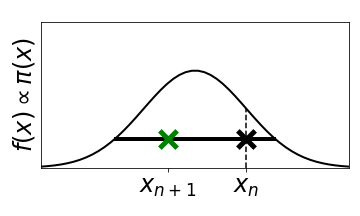

In [157]:
Image("./img/idealised.png")

This transition procedure leaves the target distribution invariant. Furthermore, if the target distribution is positive everywhere, the resulting Markov Chain is guaranteed to converge to it. This is illustrated for the Gaussian example below.

![./img/5.png](./img/5.png)
![./img/1000.png](./img/1000.png)

However, the issue with this algorithm is that in general, there is no straightforward way to sample from $S_y$. The slice $S_y$ is a union of intervals, each of which has endpoints corresponding to solutions of the equation $y = f(x)$, for which there may not be a closed form. In addition, the slice is not guaranteed to be bounded, as it could be for example a union of ever-smaller and ever far apart intervals, whose union is unbounded. The Slice Sampling alogorithm below circumvents both these issues.

Although Slice Sampling can be applied to random variables of any dimension, applying it to high-dimensional distributions presents important issues. For the moment, we focus on the one-dimensional case $D = 1$, keeping in mind that the same ideas can be applied to $D > 1$.

## The Slice Sampling algorithm

To deal with the aforementioned issues, Slice Sampling defines a bounded interval $I$ and a set $A$ and samples the new point $x_{n+1}$ uniformly from $S_y \cap I \cap A$ instead of $S_y$ - the definition and role of the set $A$ will be clarified shortly. Since the interval $I$ is bounded, so will be the above intersection. This deals with the problem of boundedness of the set we are sampling from. Now in order to deal with the issue that the slice is not available in closed form, we can simply draw repeated samples from $I$ until one falls in $S_y \cap A$. This accepted sample will be a uniform sample from $S_y \cap I \cap A$.

Depending on the choice of $I$, an appropriately chosen set $A$ is needed in order to ensure that Slice Sampling leaves the target distribution invariant. Specifically, $A$ is defined as

$$A = \{x_{n+1} : p(x_{n+1} | x_n, y) = p(x_n | x_{n+1}, y)\},$$

that is the set for which transitions $(x_n, y) \to (x_{n+1}, y)$ has the same probablity as transitions $(x_{n+1}, y) \to (x_n, y)$. For example, in the case of idealised Slice Sampling (where $I = \mathbb{R}$) the transition $(x_n, y) \to (x_{n+1}, y)$ has the same probablity as the transition $(x_{n + 1}, y) \to (x_{n}, y)$, so $A = S_y \cap I$. However, if $I \neq \mathbb{R}$ we may have to adjust $A$ appropriately.

There are several possible ways to pick a bounded interval $I$. Here we will have a look at two methods proposed by by Neal. For these two choices, we won't have $A$ in closed form, but we can determine whether a point $x_{n+1}$ is in $A$ in a computationally cheap way. In summary, here is the full Slice sampling algorithm for one dimension.

<div class='definition'>

**Definition (One dimensional slice sampling)** Given an unnormalised target distribution $f(x)$ and a current point $x_n$, slice sampling generates a new point $x_{n+1}$ as follows:
    
1. Sample $y \sim \text{Uniform}[0, f(x_{n})]$. This defines the slice set $S_y = \{x : y = f(x)\}.$
2. Generate a finite interval $I$ that contains $x_{n}$.
3. Sample $x_{n+1}$ uniformly from the set of intervals $S_y \cap I \cap A$, where
    
$$A = \{x_{n+1} : p(x_{n+1} | x_n, y) = p(x_n | x_{n+1}, y)\}.$$
    
</div>
<br>

It can be shown that the sampling algorithm defined above leaves the target distribution invariant. To show this, it is enough to show that slice sampling satisfies detailed balance.

<div class='lemma'>

**Result (Slice sampling satisfies detailed balance)** The slice-sampling transition rule satisfies detailed balance
    
$$\begin{align}
p(x_{n+1} | x_n) \pi(x_n) = p(x_n | x_{n+1}) \pi(x_{n+1}).
\end{align}$$
    
</div>
<br>


<details class="proof">
<summary> Proof: Slice sampling satisfies detailed balance </summary>

We will show that slice sampling satisfies detailed balance of the target distribution. We have
    
$$\begin{align}
p(x_{n+1} | x_n)\pi(x_n) &= \int_0^{\pi(x_n)} p(x_{n+1} | x_n, y) p(y | x_n) \pi(x_n) dy \\
                     &= \int_0^{\pi(x_n)} p(x_{n+1} | x_n, y) \frac{1}{\pi(x_n)} \pi(x_n) dy \\
                     &= \int_0^{\min(\pi(x_n), \pi(x_{n+1}))} p(x_{n+1} | x_n, y) dy,
\end{align}$$
    
where in the last line we have used the fact that

$$\begin{align}
p(x_{n+1} | x_n, y) = 0, \text{ whenever } y > \pi(x_{n+1}).
\end{align}$$
    
Similarly, going the other way we have

$$\begin{align}
p(x_n | x_{n+1})\pi(x_{n+1}) &= \int_0^{\pi(x_{n+1})} p(x_n | x_{n+1}, y) p(y | x_{n+1}) \pi(x_{n+1}) dy \\
                     &= \int_0^{\pi(x_{n+1})} p(x_n | x_{n+1}, y) \frac{1}{\pi(x_{n+1})} \pi(x_{n+1}) dy \\
                     &= \int_0^{\min(\pi(x_n), \pi(x_{n+1}))} p(x_n | x_{n+1}, y) dy.
\end{align}$$
    
Therefore, we only need to show that

$$\begin{align}
p(x_{n+1} | x_n, y) &= p(x_n | x_{n+1}, y),
\end{align}$$

which is follows by the definition of $A$. In particular, since $x_{n+1}$ is sampled from $S_y \cap A \cap I$, it will be in $A$. Since $A$ is defined as

$$A = \{x_{n+1} : p(x_{n+1} | x_n, y) = p(x_n | x_{n+1}, y)\},$$

it follows that $p(x_{n+1} | x_n, y) = p(x_n | x_{n+1}, y)$. This proof in offloads a bit of the work to the definition of $A$, which we will discuss shortly.
    
</details>
<br>

Note also that the above algorithm is a special case of the more general "crumb" framework.{cite}`neal2003slice` Crumb-based slice sampling is not constained to generating an $I$ and sampling from a subset of it, although methods that do so can be cast as crumb-based methods. Crumb-based methods are very general and therefore ammeanable to a great deal of tuning and design choices, which are beyond the scope of this page, so we won't look into them here. We now look at the details of the interval $I$ and set $A$.

## Defining the interval $I$

We could define $I$ to be a constant-size interval and use this throughout the run of the chain. However, if our choice of $I$ is small compared to the lengthscale of $\pi$, the chain will move slowly - slower than what it could if $I$ was larger. Similarly, if $I$ is too large, we may end up drawing several samples from $I$ until we draw an accpetable point (that is a point in $S_y \cap A$). Lastly, the appropriate size of $I$ may be different for different regions of the target distribution. Therefore, the best solution would be have $I$ adapt to the distribution. Neal proposes{cite}`neal2003slice` two methods to produce adaptive intervals $I$: the step-out method and the doubling method. We will discuss each in turn.

### Step-out method

Starting from an interval $I = [L, R]$ of initial width $w = (R - L)$ containing $x_n$, we could expand it to the left in steps of $w$ until the left endpoint is outside the slice or until a maximum expansion budget $N_L$ is reached. We can repeat this expansion to the right with a corresponding budget $N_R$. The resulting interval $I$ contains $x_n$ and (hopefully) a considerable part of the slice $S_y$. There remains the question of how to choose the initial $L$ and $R$. Neal chooses to set{cite}`neal2003slice` $L$ and $R$ uniformly at random, such $R - L = w$ and $x_n \in [L, R]$. We will show that in this case $A = S_y \cap I$.

![./img/stepout-full.png](./img/stepout-full.png)

The step-out procedure is illustrated in the image above. Starting from the black cross, we sample the initial endpoints of the interval (innermost blue and red crosses), as well as the expansion budgets. We then step out to the left and to the right until a point outside the slice is reached. After expanding to the left and to the right we are left with the interval $I$ - the solid horizontal line. This is summarised by the algorithm below.

<div class='definition'>

**Definition (Step-out method)** Given $f, x_n, y$, positive integer $m$ and positive real $w > 0$, the step-out method produces an interval $I = [L, R]$ containing $x_n$ as follows
    
1. Sample $U, V \sim \text{Uniform}[0, 1]$.
2. Initialise endpoints $L = x_n - wU$ and $R = x_n + w$, and budgets $N_L = \lfloor mV\rfloor$ and $N_R = (m - 1) - N_L$.
3. While $N_L > 0$ and $y \leq f(L)$ update $L \leftarrow L - w$, $N_L \leftarrow N_L - 1$.
4. While $N_R > 0$ and $y \leq f(R)$ update $R \leftarrow R + w$, $N_R \leftarrow N_R - 1$.
    
</div>
<br>

Below is a function implementing the stepout method. It takes in an initial point represented by `x` and `y` (note `y` is a log-probability), a function `log_prob` returning the log-probability of the target $\pi$, the step-out width `w` and the maximum number of expansions `m`. It returns `L` and `R` representing the expanded iterval $I$.

In [158]:
def step_out_expansion(x, y, log_prob, w, m):
    
    U = np.random.rand()
    L = x - w * U
    R = L + w
    
    Lhist = [L]
    Rhist = [R]
    
    J = np.floor(m * np.random.rand())
    K = m - 1 - J
    
    logprobL = log_prob(L)
    logprobR = log_prob(R)
    
    while J > 0 and y <= logprobL:
        
        L = L - w
        J = J - 1
        logprobL = log_prob(L)
        
        Lhist.append(L)
        
    while K > 0 and y <= logprobR:
        
        R = R + w
        K = K - 1
        logprobR = log_prob(R)
        
        Rhist.append(R)
        
    return L, R, (Lhist, Rhist)

Let's create a slightly more interesting mixture-of-gaussians log-probability function to experiment with.

In [159]:
def mixture_of_gaussians_log_prob(x, means, variances, weights):
    
    assert np.sum(weights) == 1.
        
    x = np.array(x)
    x = x.reshape((1, 1))

    means = means[:, None]
    variances = variances[:, None]

    coeff = (2 * np.pi * variances) ** -0.5
    exp = np.exp(-0.5 * (x - means) ** 2 / variances)

    return np.log(np.sum(weights * coeff * exp))

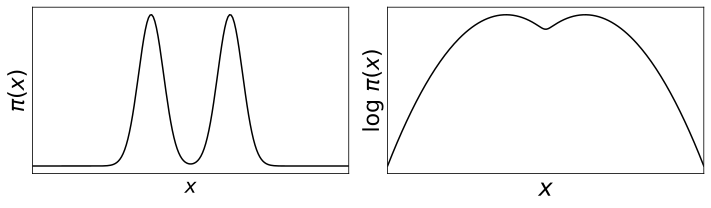

In [160]:
# Means and variances of mixture of 1D Gaussians
means = np.array([-1e0, 1e0])
variances = np.array([1e-1, 1e-1])
weights = np.array([5e-1, 5e-1])

# Function returning the log-probability at x
log_prob = lambda x : mixture_of_gaussians_log_prob(x=x,
                                                    means=means,
                                                    variances=variances,
                                                    weights=weights)

# Locations at which to compute log-probabilites
xs = np.linspace(-4, 4, 200)

# Compute log probabilities of the target
log_probs = [log_prob(x) for x in xs]

# Plot the target and the log-target
plt.figure(figsize=(10, 3))

plt.subplot(121)
plt.plot(xs, np.exp(log_probs), color='k')
plt.xlabel('$x$', fontsize=20)
plt.ylabel('$\pi(x)$', fontsize=22)
plt.xticks([])
plt.yticks([])
plt.xlim([-4, 4])

plt.subplot(122)
plt.plot(xs, log_probs, color='k')
plt.xlabel('$x$', fontsize=24)
plt.ylabel('$\log~\pi(x)$', fontsize=22)
plt.xlim([-4, 4])
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

The only parameters of the step-out method are the step size $w$ and maximum number of expansions $m$. Depending on the values of $w$ and $m$ used, we may obtain different expanded intervals $I$. Below, it just so happened that after the first expansion to the right, the right endpoint (red cross next to black cross) was still inside the slice $S_y$, so the step-out expansion was continued.

In [161]:
# Means and variances of mixture of 1D Gaussians
means = np.array([-1e0, 1e0])
variances = np.array([1e-1, 1e-1])
weights = np.array([5e-1, 5e-1])

# Function returning the log-probability at x
log_prob = lambda x : mixture_of_gaussians_log_prob(x=x,
                                                    means=means,
                                                    variances=variances,
                                                    weights=weights)

# Set initial point (x, y) - note that y is in log-probability space
x = -1.
y = np.log(0.5)

# Set interval step sizes w and maximum expansion budget m
w = 3
m = 4

# Set random seed
np.random.seed(1)

# Apply the step-out method
L, R, (Lhist, Rhist) = step_out_expansion(x=x, y=y, log_prob=log_prob, w=w, m=m)

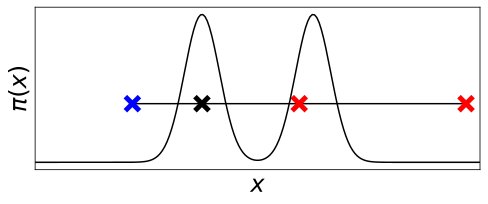

In [162]:
plt.figure(figsize=(8, 3))
plt.plot(xs, np.exp(log_probs), color='black')
plt.plot([Lhist[-1], Rhist[-1]], [np.exp(y), np.exp(y)], color='black', zorder=1)
plt.scatter(x, np.exp(y), color='black', marker='x', s=200, linewidth=5, zorder=3)
plt.scatter(Lhist, np.exp(y) * np.ones_like(Lhist), color='blue', marker='x', s=200, linewidth=5, zorder=2)
plt.scatter(Rhist, np.exp(y) * np.ones_like(Rhist), color='red', marker='x', s=200, linewidth=5, zorder=2)

plt.xlabel(r'$x$', fontsize=24)
plt.ylabel(r'$\pi(x)$', fontsize=24)
plt.xticks([])
plt.yticks([])
plt.xlim([-4, 4])

plt.show()

### Doubling method

An alternative to the step-out method is the doubling method, which instead of expanding $I$ linearly, it doubles its size. At each step, this method tosses a coin and doubles the interval $I$ by adding another interval of equal size either to the left or to the right side of $I$. The algorithm terminates once both left and right endpoints of $I$ are outside the slice or when an expansion budget $p$ is reached.

<div class='definition'>

**Definition (Doubling method)** Given $f, x_n, y$, positive integer $p$ and positive real $w > 0$, the step-out method produces an interval $I = [L, R]$ containing $x_n$, as follows
    
1. Sample $U \sim \text{Uniform}[0, 1]$.
2. Initialise endpoints $L = x_n - wU$ and $R = x_n + w$ and budget $K = p$.
3. While $K > 0$ and $(y < f(L) \text{ or } y < f(R))$, sample $V \sim \text{Uniform}[0, 1]$ and update 
    
    $$\begin{align}
L \leftarrow L - (R - L) &&\text{ if } V < \frac{1}{2} \\
R \leftarrow R + (R - L) &&\text{ otherwise}.
\end{align}$$
    
</div>
<br>

Below is a function implementing the doubling method. Like the step-out method, it takes in an initial point represented by `x` and `y` (note again `y` is a log-probability), a `log_prob` function, the step-out and an initial width `w`, as well as the maximum number of doublings `p`. It returns `L` and `R` representing the expanded iterval $I$.

In [165]:
def double_expansion(x, y, log_prob, w, p):
    
    U = np.random.uniform()
    L = x - w * U
    R = L + w
    K = p
    
    Lhist = [L]
    Rhist = [R]
    
    logprobL = log_prob(L)
    logprobR = log_prob(R)
    
    while K > 0 and (logprobL > y or logprobR > y):
        
        V = np.random.uniform()
        
        if V > 0.5:
            L = L - (R - L)
            logprobL = log_prob(L)
            
        else:
            R = R + (R - L)
            logprobR = log_prob(R)
        
        Lhist.append(L)
        Rhist.append(R)
        
        K = K - 1
            
    return L, R, (Lhist, Rhist)

Just as with the step-out method, we can apply the doubling method to the mixture of gaussians example and observe the resulting $I$. In the case below, the right endpoint (red cross) is outside the slice $S_y$ but the initial left endpoint (right blue cross) was inside the slice, so the algorithm did one doubling (which happened to be on the left), produced an interval $I$ with both endpoints outside the slice and stopped.

In [211]:
# Means and variances of mixture of 1D Gaussians
means = np.array([-1e0, 1e0])
variances = np.array([1e-1, 1e-1])
weights = np.array([5e-1, 5e-1])

# Function returning the log-probability at x
log_prob = lambda x : mixture_of_gaussians_log_prob(x=x,
                                                    means=means,
                                                    variances=variances,
                                                    weights=weights)

# Set initial point (x, y) - note that y is in log-probability space
x = -1.
y = np.log(0.5)

# Set interval step sizes w and maximum expansion budget m
w = 1
p = 2

# Set random seed
np.random.seed(1)

# Apply the step-out method
L, R, (Lhist, Rhist) = double_expansion(x=x, y=y, log_prob=log_prob, w=w, p=p)

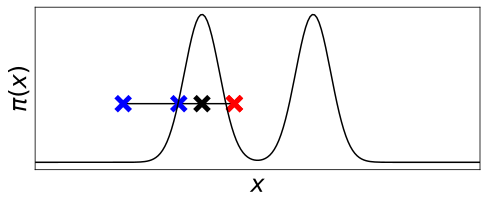

In [212]:
plt.figure(figsize=(8, 3))
plt.plot(xs, np.exp(log_probs), color='black')
plt.plot([Lhist[-1], Rhist[-1]], [np.exp(y), np.exp(y)], color='black', zorder=1)
plt.scatter(x, np.exp(y), color='black', marker='x', s=200, linewidth=5, zorder=3)
plt.scatter(Lhist, np.exp(y) * np.ones_like(Lhist), color='blue', marker='x', s=200, linewidth=5, zorder=2)
plt.scatter(Rhist, np.exp(y) * np.ones_like(Rhist), color='red', marker='x', s=200, linewidth=5, zorder=2)

plt.xlabel(r'$x$', fontsize=24)
plt.ylabel(r'$\pi(x)$', fontsize=24)
plt.xticks([])
plt.yticks([])
plt.xlim([-4, 4])

plt.show()

## Sampling and the $A$ set

Once we have generated our set $I$, it remains to sample from $S_y \cap I \cap A$, where the set $A$ was defined as

$$A = \{x_{n+1} : p(x_{n+1} | x_n, y) = p(x_n | x_{n+1}, y)\}.$$

Neal{cite}`neal2003slice` discusses two methods to achieve this. One is to sample points uniformly from $I$ until a point which lies in $S_y \cap A$ is found, let's refer to this as repeated sampling. We can easily check whether a point lies in the slice $S_y$. In addition, checking whether a point lies in $A$ is easy when $I$ has been generated with the step-out or the doubling method - we discuss this shortly.

A variant of this scheme for sampling from $S_y \cap I \cap A$ is as follows. If while sampling $I$ a point is found to lie outside $S_y$ we can shrink $I$ accordingly, making the new sample the left (right) endpoint of $I$ if it lies to the left (right) of the current point $x_n$. Let's refer to this as the shrinkage method. The shrinkage method is likely to produce an accepted sample faster than the repeated sampling method, however (if the target is multimodal) it may also result in shrinking $I$ and cutting off parts of the slice that the algorithm could transition to. At any rate, the choice of using either of these methods does not appear to be performance-critical.

Below is an implmementation for sampling the acceptable set, handling both expansion methods. It takes in the current point represented by `x` and `y` and returns a sample from a uniform distribution over $S_y \cap I \cap A$.

In [213]:
def sample_acceptable_set(x0, y, L, R, log_prob, method, params, shrinkage):
    
    L0, R0 = L, R
    
    while True:
        
        x = L + (R - L) * np.random.rand()
        
        accept = is_acceptable(x, y, L0, R0, log_prob, method, params)
        
        if accept:
            return x
        
        elif shrinkage and x < x0:
            L = x
            
        elif shrinkage and x > x0:
            R = x

We now turn to the final detail, of checking whether a candidate point is in $A$. For the step-out method, $A = S_y \cap I$, so we need not check at all. For the doubling method, we can trace back the doubling procedure to determine if the expanded interval $I$ could have been generated by a doubling procedure starting from the candidate point $x_{n+1}$.

<div class='lemma'>

**Result (Acceptable sets for step-out/doubling methods)** Starting from the point $x_n$, the acceptable set
    
$$A = \{x_{n+1} : p(x_{n+1} | x_n, y) = p(x_n | x_{n+1}, y)\}$$
    
is equal to $S_y \cap I$ for the step-out method, where $I$ is the interval expanded from $x_n$ using parameters $w, m$. For the doubling method, we can determine whether a candidate point $x_{n+1}$ is in the acceptable set $A$ defined by $x_n, y, w, p, I$ using the following procedure
    
1. Initialise $[L, R] = I$.
2. While $R - L > w$ repeat

    2.1 Set $M = (L + R)~/~2$, and update $L, R$ according to
    
    $$\begin{align}
L \leftarrow M &&\text{ if } M \geq x_n \\
R \leftarrow M &&\text{ otherwise}.
\end{align}$$
    
    2.2 If $y \geq f(L)$ and $y \geq f(R)$, $x$ is not acceptable.
3. If $x$ is not rejected in the above loop, it is acceptable.
    
</div>
<br>

<details class="proof">
<summary> Proof: Acceptable sets for step-out/doubling methods</summary>
    
We will show that if a point $(x_{n+1}, y)$ is accepted by the checking procedure specified above (for either the step-out or the doubling method), then the probability of generating an expanded interval $I$ given an initial point $(x_n, y)$ is equal to the probability of generating an expanded interval $I$ given an initial point $(x_{n+1}, y)$. In other words we will show that if $x_{n+1} \in A$, then
    
$$ p(I | x_n, y) = p(I | x_{n+1}, y).$$
    
Therefore, since $x_n$ and $x_{n+1}$ have equal probability of 
    
**$A = S_y \cap I$ for the step-out method:** Suppose that starting from $(x_n, y)$, we sample $U$ and $N_L$ as specified above, that is
    
$$\begin{align}
U &\sim \text{Uniform}[0, 1], \\
N_L &\sim \text{Uniform}\{0, 1, ..., m - 1\}.
\end{align}$$
    
The initial interval prior to expansion is $I_0 = [x_n - wU, x_n + w (1 - U)]$. Now suppose we apply the step out method to obtain the expanded interval $I$ and then sample $x_{n+1} \sim \text{Unifrom}[S_y \cap I]$. Since $x_{n+1} \in I$, the point $x_{n+1}$ is contained in an interval of width $w$ which was added onto $I$ while expanding it, that is
    
$$x_{n+1} \in I_0' = [x_n + w(k - U), x_n + w (k + 1 + U)]$$
    
for some $- N_L \leq k \leq N_R - 1$. Now, starting from $(x_{n+1}, y)$ there exists a unique $U' \in [0, 1]$ such that the initial interval is equal to $I_0'$
    
$$I_0' = [x_{n + 1} - wU', x_{n + 1} + (1 - w) U'], \text{ for some unique } U' \in [0, 1].$$
    
Now, expanding $I_0'$ from $(x_{n+1}, y)$ will result in the same interval endpoints as when expanding $I_0$ from $(x_n, y)$ except if the $I_0'$ expansion is stopped by the budget. But since $x_{n+1} \in I_0'$, there exist budgets $N_L' \in \{0, 1, ..., m - 1\}$ which will result in expanding $I_0'$ to obtain exactly $I$. The number of distinct budgets $N_L$ which will result in expanding $I_0$ to $I$ and the number of distinct budgets $N_L'$ which will result in expanding $I_0'$ to $I$, are the same. Therefore, the probability of starting from $(x_n, y)$ and transitioning to $(x_{n+1}, y)$ is the same as the other way around and thus $A = S_y \cap I$.
    
</details>
<br>

In [19]:
def is_acceptable(x, y, L, R, log_prob, method, params):
    
    # Function value at candidate point
    f = log_prob(x)
    
    # For stepping out, check x is in the slice (y < f)
    if method == 'step_out':
        
        if y <= f:
            return True
        
        else:
            return False
    
    # For doubling, check the doubling sequence can be recreated the other way
    elif method == 'double':
        
        w, p = params
        
        fx = log_prob(x)
        
        while R - L > 1.5 * w:
            
            M = (R + L) / 2
            
            logprobL = log_prob(L)
            fM = log_prob(M)
            logprobR = log_prob(R)
            
            if x >= M and (y < fM or y < logprobR): L = M
                
            elif x < M and (y < logprobL or y < fM): R = M
            
            else: return False
            
        # If the point is not rejcected in the loop, it is acceptable
        return True

## The Slice Sampling algorithm

Putting it all together, we have a complete MCMC algorithm for sampling from $1$-dimensional distributions. The function `slice_sampling_transition` applies a single Slice Sampling based transition and returns the result.

In [20]:
def slice_sampling_transition(x, log_prob, method, params, shrinkage):
    
    f = log_prob(x)
    y = np.log(np.exp(f) * np.random.rand())
    
    L = None
    R = None
    
    if method == 'step_out':
        w, m = params
        L, R, _ = step_out_expansion(x, y, log_prob, w, m)
        
    elif method == 'double':
        w, p = params
        L, R, _ = double_expansion(x, y, log_prob, w, p)
        
    x = sample_acceptable_set(x=x,
                              y=y,
                              L=L,
                              R=R,
                              log_prob=log_prob,
                              method=method,
                              params=params,
                              shrinkage=shrinkage)
    
    return x

## References

```{bibliography} ./references.bib
```